In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"
os.chdir("..")
import sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.completer import complete_by_mean_col, complete_by_mean_col_v2
from utils.completer import complete_by_multi, complete_by_multi_v2
from utils.completer import complete_by_similar_row, complete_by_similar_row_v2
from utils.generator import gen_complete_random
from utils.data import create_adult_dataset

### Learning Fair Representations (LFR)
[example notebook](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_lfr.ipynb)  

------

The idea is to first apply imputation on original dataset (adult dataset here)  
Then feed the converted dataset into LFR to see any difference  

------

Note:  
In order to LFR to work on Python3.8  
Should install LFR directly from github, instead of from pip  

In [2]:
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.lfr import LFR

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [4]:
data = create_adult_dataset()
print(data.X.shape)
print(data.X.isnull().sum().sum())

(32561, 10)
0


In [5]:
data_incomplete = gen_complete_random(data, random_ratio=0.2)
print(data_incomplete.X.isnull().sum())

gen_complete_random: 58244 NaN values have been inserted
age               6417
workclass         6475
education         6426
education-num     6527
marital-status    6464
occupation        6474
relationship      6460
race              6468
hours-per-week    6533
sex                  0
dtype: int64


In [6]:
data_complete = complete_by_mean_col(data_incomplete)
print(data_complete.X.isnull().sum())

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
hours-per-week    0
sex               0
dtype: int64


In [7]:
data_complete.y_encoder.classes_

array([' <=50K', ' >50K'], dtype=object)

In [8]:
data_complete.categorical_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race']

In [9]:
data_complete.protected_features

['sex']

In [10]:
# convert to standard dataset
from sklearn.model_selection import train_test_split
tmp_df = pd.concat([data_complete.X, pd.DataFrame(data_complete.y, columns=["_TARGET_"])], axis=1).copy()
tmp_df['sex'] = tmp_df['sex'].apply(lambda x : 0.0 if x == ' Female' else 1.0) # necessary for aif360 to understand
tmp_df_train, tmp_df_test = train_test_split(tmp_df, test_size=0.3, shuffle=True)
data_imputed_train = StandardDataset(df=tmp_df_train, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                     protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                     features_to_keep=data_complete.X.columns.tolist(),
                                     instance_weights_name=None, features_to_drop=[],
                                     custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_imputed_test = StandardDataset(df=tmp_df_test, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                    protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                    features_to_keep=data_complete.X.columns.tolist(),
                                    instance_weights_name=None, features_to_drop=[],
                                    custom_preprocessing=None, categorical_features=data_complete.categorical_features)
print(tmp_df_train.shape)
print(tmp_df_test.shape)

(22792, 11)
(9769, 11)


In [11]:
privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]
metric_imputed_train = BinaryLabelDatasetMetric(data_imputed_train, 
                                                unprivileged_groups=unprivileged_groups,
                                                privileged_groups=privileged_groups)
metric_imputed_test = BinaryLabelDatasetMetric(data_imputed_test, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
print(metric_imputed_train.mean_difference())
print(metric_imputed_test.mean_difference())

-0.19535371446387162
-0.1986565160302357


In [12]:
scaler = StandardScaler()
data_imputed_train.features = scaler.fit_transform(data_imputed_train.features)
data_imputed_test.features = scaler.transform(data_imputed_test.features)

In [13]:
TR = LFR(unprivileged_groups=[{'sex': 0}],
         privileged_groups=[{'sex': 1}],
         k=10, Ax=0.01, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(data_imputed_train, maxiter=5000, maxfun=5000)

step: 0, loss: 0.6330668625124511, L_x: 2.515999139671763,  L_y: 0.5950254342795586,  L_z: 0.006440718418087489
step: 250, loss: 0.6330668667437016, L_x: 2.515999162532844,  L_y: 0.5950254371324457,  L_z: 0.006440718992963744
step: 500, loss: 0.6330668713021544, L_x: 2.5159991634776926,  L_y: 0.595025434566718,  L_z: 0.006440722550329768
step: 750, loss: 0.6049685127209173, L_x: 2.515997163869673,  L_y: 0.5673053752925831,  L_z: 0.0062515828948187776
step: 1000, loss: 0.6049684885283863, L_x: 2.5159971579743425,  L_y: 0.5673053554411118,  L_z: 0.00625158075376549
step: 1250, loss: 0.6049684865974035, L_x: 2.515997180859867,  L_y: 0.5673053548130943,  L_z: 0.006251579987855289
step: 1500, loss: 0.5872575825438495, L_x: 2.5158156299998944,  L_y: 0.5510041519076877,  L_z: 0.005547637168081458
step: 1750, loss: 0.5872575912870602, L_x: 2.515815654763159,  L_y: 0.5510041564886694,  L_z: 0.005547639125379653
step: 2000, loss: 0.5844839805229505, L_x: 2.5157056686494874,  L_y: 0.5491057927524

In [14]:
data_imputed_transf_train = TR.transform(data_imputed_train)
data_imputed_transf_test = TR.transform(data_imputed_test)
print(classification_report(data_imputed_test.labels, data_imputed_transf_test.labels, zero_division=0))
metric_imputed_transf_train = BinaryLabelDatasetMetric(data_imputed_transf_train, 
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
metric_imputed_transf_test = BinaryLabelDatasetMetric(data_imputed_transf_test, 
                                                      unprivileged_groups=unprivileged_groups,
                                                      privileged_groups=privileged_groups)
print(metric_imputed_transf_train.mean_difference())
print(metric_imputed_transf_test.mean_difference())

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87      7478
         1.0       0.00      0.00      0.00      2291

    accuracy                           0.77      9769
   macro avg       0.38      0.50      0.43      9769
weighted avg       0.59      0.77      0.66      9769

0.0
0.0


In [15]:
def draw(dataset_orig_test, dataset_transf_test):
    from collections import OrderedDict
    from aif360.metrics import ClassificationMetric

    def compute_metrics(dataset_true, dataset_pred, 
                        unprivileged_groups, privileged_groups,
                        disp = True):
        """ Compute the key metrics """
        classified_metric_pred = ClassificationMetric(dataset_true,
                                                     dataset_pred, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        metrics = OrderedDict()
        metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                                 classified_metric_pred.true_negative_rate())
        metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
        metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
        metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
        metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
        metrics["Theil index"] = classified_metric_pred.theil_index()
    
        if disp:
            for k in metrics:
                print("%s = %.4f" % (k, metrics[k]))
    
        return metrics
    bal_acc_arr_transf = []
    disp_imp_arr_transf = []

    class_thresh_arr = np.linspace(0.01, 0.99, 100)

    dataset_transf_test_new = dataset_orig_test.copy(deepcopy=True)
    dataset_transf_test_new.scores = dataset_transf_test.scores

    for thresh in class_thresh_arr:
        fav_inds = dataset_transf_test_new.scores > thresh
        dataset_transf_test_new.labels[fav_inds] = 1.0
        dataset_transf_test_new.labels[~fav_inds] = 0.0
    
        metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_new, 
                                          unprivileged_groups, privileged_groups,
                                          disp = False)

        bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
        disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(class_thresh_arr, bal_acc_arr_transf)
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)

    ax2 = ax1.twinx()
    ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
    ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    plt.show()

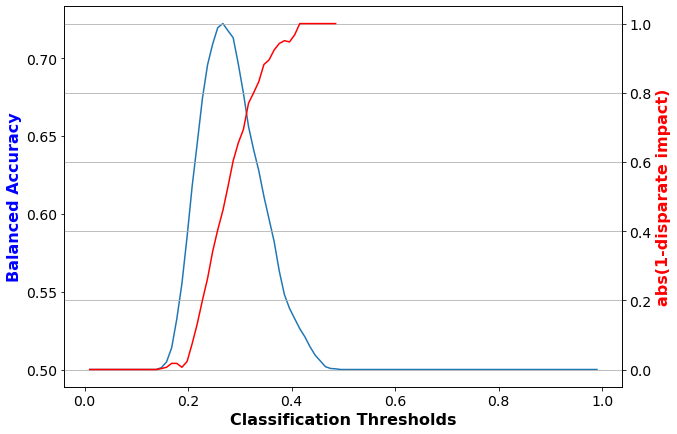

In [16]:
draw(data_imputed_test, data_imputed_transf_test)

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

In [17]:
# compare with original dataset
tmp_df = pd.concat([data.X, pd.DataFrame(data.y, columns=["_TARGET_"])], axis=1).copy()
tmp_df['sex'] = tmp_df['sex'].apply(lambda x : 0.0 if x == ' Female' else 1.0) # necessary for aif360 to understand
tmp_df_train, tmp_df_test = train_test_split(tmp_df, test_size=0.3, shuffle=True)
data_train = StandardDataset(df=tmp_df_train, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                             protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                             features_to_keep=data_complete.X.columns.tolist(),
                             instance_weights_name=None, features_to_drop=[],
                             custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_test = StandardDataset(df=tmp_df_test, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                            protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                            features_to_keep=data_complete.X.columns.tolist(),
                            instance_weights_name=None, features_to_drop=[],
                            custom_preprocessing=None, categorical_features=data_complete.categorical_features)
print(tmp_df_train.shape)
print(tmp_df_test.shape)
metric_train = BinaryLabelDatasetMetric(data_train, 
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
metric_test = BinaryLabelDatasetMetric(data_test, 
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
print(metric_train.mean_difference())
print(metric_test.mean_difference())

(22792, 11)
(9769, 11)
-0.196041259710924
-0.19681066423191743


In [18]:
data_train.features = scaler.fit_transform(data_train.features)
data_test.features = scaler.transform(data_test.features)
TR = LFR(unprivileged_groups=[{'sex': 0}],
         privileged_groups=[{'sex': 1}],
         k=10, Ax=0.01, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(data_train, maxiter=5000, maxfun=5000)

step: 0, loss: 0.6456873545056394, L_x: 2.5139431284167046,  L_y: 0.6015359259448135,  L_z: 0.009505998638329387
step: 250, loss: 0.6456873586493069, L_x: 2.513943148309826,  L_y: 0.6015359318465011,  L_z: 0.009505997659853762
step: 500, loss: 0.6456873903668052, L_x: 2.5139431404506425,  L_y: 0.6015359416894337,  L_z: 0.009506008636432544
step: 750, loss: 0.6151353469092433, L_x: 2.5141601442669876,  L_y: 0.5716311722658431,  L_z: 0.009181286600365149
step: 1000, loss: 0.6151353758672694, L_x: 2.5141601390797383,  L_y: 0.5716312039376534,  L_z: 0.009181285269409293
step: 1250, loss: 0.6151353755440434, L_x: 2.5141601431959115,  L_y: 0.571631197553485,  L_z: 0.009181288279299633
step: 1500, loss: 0.5883921413431303, L_x: 2.514791379999536,  L_y: 0.5477404687317847,  L_z: 0.007751879405675122
step: 1750, loss: 0.588392141023176, L_x: 2.514791387044003,  L_y: 0.5477404672159647,  L_z: 0.007751879968385683
step: 2000, loss: 0.5842876017532233, L_x: 2.5150285257159553,  L_y: 0.545320645725

In [19]:
data_transf_train = TR.transform(data_train)
data_transf_test = TR.transform(data_test)
print(classification_report(data_test.labels, data_transf_test.labels, zero_division=0))
metric_transf_train = BinaryLabelDatasetMetric(data_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
metric_transf_test = BinaryLabelDatasetMetric(data_transf_test, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)
print(metric_transf_train.mean_difference())
print(metric_transf_test.mean_difference())

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      7379
         1.0       0.00      0.00      0.00      2390

    accuracy                           0.76      9769
   macro avg       0.38      0.50      0.43      9769
weighted avg       0.57      0.76      0.65      9769

0.0
0.0


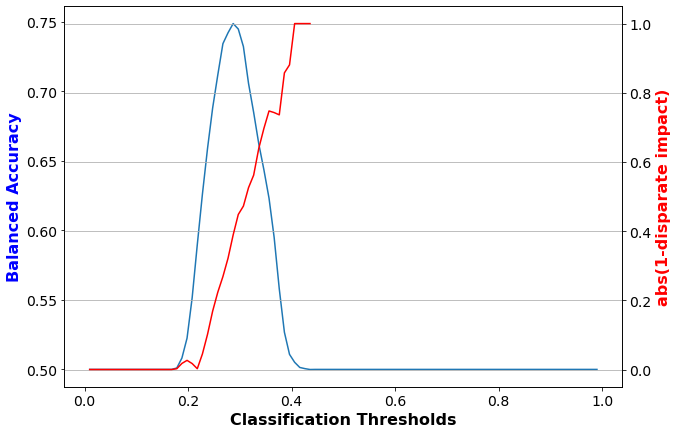

In [20]:
draw(data_test, data_transf_test)

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

In [21]:
# compare consistency
print("Consistency of labels in imputed transformed training dataset= %f" %metric_imputed_transf_train.consistency())
print("Consistency of labels in imputed training dataset= %f" %metric_imputed_train.consistency())
print("Consistency of labels in imputed transformed test dataset= %f" %metric_imputed_transf_test.consistency())
print("Consistency of labels in imputed test dataset= %f" %metric_imputed_test.consistency())

Consistency of labels in imputed transformed training dataset= 1.000000
Consistency of labels in imputed training dataset= 0.803764
Consistency of labels in imputed transformed test dataset= 1.000000
Consistency of labels in imputed test dataset= 0.805671


In [22]:
print("Consistency of labels in transformed training dataset= %f" %metric_transf_train.consistency())
print("Consistency of labels in original training dataset= %f" %metric_train.consistency())
print("Consistency of labels in transformed test dataset= %f" %metric_transf_test.consistency())
print("Consistency of labels in original test dataset= %f" %metric_test.consistency())

Consistency of labels in transformed training dataset= 1.000000
Consistency of labels in original training dataset= 0.824342
Consistency of labels in transformed test dataset= 1.000000
Consistency of labels in original test dataset= 0.816931


### Try AIF360 Preprocessed Dataset

step: 0, loss: 0.9169361306618308, L_x: 2.5109538658103254,  L_y: 0.6501489363650225,  L_z: 0.007845903857887889
step: 250, loss: 0.8584054817309023, L_x: 2.5088155841368995,  L_y: 0.5926804283864011,  L_z: 0.007421747465405598
step: 500, loss: 0.8211589394440812, L_x: 2.4995390096438213,  L_y: 0.5579599843098451,  L_z: 0.006622527084927043
step: 750, loss: 0.8168697826288129, L_x: 2.494595874470528,  L_y: 0.55575185120256,  L_z: 0.005829171989600099
step: 1000, loss: 0.7927979281731651, L_x: 2.405453918941696,  L_y: 0.5413116085728181,  L_z: 0.005470463853088611
step: 1250, loss: 0.7767318512803684, L_x: 2.304729600176352,  L_y: 0.5313435976921733,  L_z: 0.007457646785279886
step: 1500, loss: 0.7494182348319292, L_x: 2.148495732964618,  L_y: 0.5107504866669568,  L_z: 0.01190908743425528
step: 1750, loss: 0.7032452955451245, L_x: 1.8804727381327186,  L_y: 0.4729354010888402,  L_z: 0.021131310321506197
step: 2000, loss: 0.6964150732084035, L_x: 1.8795397030406478,  L_y: 0.46908419221383

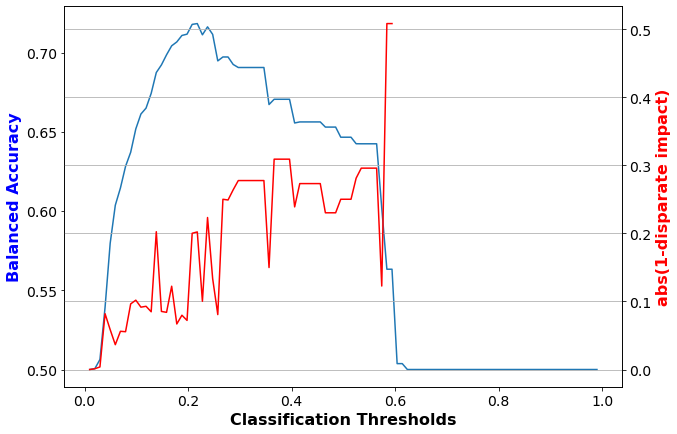

In [23]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
dataset_orig = load_preproc_data_adult()
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)
scale_orig = StandardScaler()
dataset_orig_train.features = scale_orig.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = scale_orig.transform(dataset_orig_test.features)
TR = LFR(unprivileged_groups=[{'sex': 0}],
         privileged_groups=[{'sex': 1}],
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(dataset_orig_train, maxiter=5000, maxfun=5000)
dataset_transf_train = TR.transform(dataset_orig_train)
dataset_transf_test = TR.transform(dataset_orig_test)
draw(dataset_orig_test, dataset_transf_test)

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

In [25]:
print(classification_report(dataset_orig_test.labels, dataset_transf_test.labels, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87     11216
         1.0       0.56      0.38      0.46      3437

    accuracy                           0.79     14653
   macro avg       0.70      0.65      0.66     14653
weighted avg       0.77      0.79      0.77     14653



In [26]:
metric_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
metric_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)
print("Consistency of labels in transformed training dataset= %f" %metric_transf_train.consistency())
print("Consistency of labels in original training dataset= %f" %metric_train.consistency())
print("Consistency of labels in transformed test dataset= %f" %metric_transf_test.consistency())
print("Consistency of labels in original test dataset= %f" %metric_test.consistency())

Consistency of labels in transformed training dataset= 1.000000
Consistency of labels in original training dataset= 0.742286
Consistency of labels in transformed test dataset= 1.000000
Consistency of labels in original test dataset= 0.739303


Consistency:  
Individual fairness metric from that measures how similar the labels are for similar instances.  
$$1 - \frac{1}{n\cdot\text{n_neighbors}}\sum_{i=1}^n |\hat{y}_i - \sum_{j \in\mathcal{N}_{\text{n_neighbors}}(x_i)} \hat{y}_j|$$

Mean Difference (Statistical Parity Differences):  
$$Pr(Y = 1 | D = \text{unprivileged}) - Pr(Y = 1 | D = \text{privileged})$$

Disparate Impact:  
$$\frac{Pr(Y = 1 | D = \text{unprivileged})}{Pr(Y = 1 | D = \text{privileged})}$$

LFR Args:  
* k (int, optional): Number of prototypes.  
* Ax (float, optional): Input recontruction quality term weight.  
* Az (float, optional): Fairness constraint term weight.  
* Ay (float, optional): Output prediction error.  

Defined in [Paper](http://www.cs.toronto.edu/~toni/Papers/icml-final.pdf), page 3